# CS524 Project: Flux Balance Analysis for Metabolic Networks

> **About this notebook** 
> The notebook contains two parts:
> - In the first part, I will go through the approaches, build and solve the optimization models on an example case, and show some post-analysis. This corresponds to the sections 2, 3, 4 required by the final report. I do this becaues my project actually have 3 sub-problems per case, and I think this is better for the reader to understand. 
> - In the second part, I will wrap the whole procedure into a general solver application.
A user can use this to find solution to any organism in a list (yeast, mouse, E. Coli) or
compare performances. I then show some additional results.

---

## 1. Introduction
Biological systems has numerous interconnected
metabolic (chemical) reactions that convert nutrients into energy, biomass, and other products, forming a large **metabolic network**. Understanding how the reaction ﬂuxes are distributed across a metabolic network is an important question in biology. However, it is hard to obtain from experimental measurements, as there is no method that can monitor all reactions at the same time.

Flux Balance Analysis (FBA) is a computational
method to model the reaction ﬂuxes in a metabolic network with a steady state assumption. It uses a
complete set of all reactions in a cell/organism, and formulate a linear program model to
optimize a biological objective such as growth rate, and hence obtaining a metabolic network model with optimal ﬂux distribution. FBA is an important tool and has been implemented in some bioinformatics softwares. 

> Experimentally determining all the indentities of reactions in a cell is a relatively easy task: these reactions are catalyzed by certain enzymes (or just exchanging some substances with the exter al space), and scientists can read from the genome (all genes) of an organism and know what enzymes it has, corresponding to what reactions is has.

In this project, I will use the idea of FBA
to construct metabolic models using public data, and then perform subsequent analyses. These contains finding critical pathways and flux variability analysis, which are also biological-relevant tasks. The methods of them will be detailed in section 3 with implementation in GAMSPy.

## 2. Data

### 2.1 The data pipeline
The data we use in this project comes from the BiGG Models [http://bigg.ucsd.edu/](http://bigg.ucsd.edu/).
These are raw data come from experimental measurement of all metabolites (i.e. intermeidate substrates) and 
all reactions and their identities. They are stored in JSON format, and we will first transform to DataFrames, then to GAMSPy parameters.

The common objective of optimization for simple organisms are defined as "biomass accumulation". This is an idea similar to taking into some nutrient and grow, and it wants to maximize the growth rate. People have defined some biomass reaction which transform certain amounts of a set of metabolites into "biomass".
However, for more complex living systems, like human, there is not a simple objective like this. Researchers are likely to define some objective of interest, like maximizing "something", based on what they are studying, so a biomass reaction is not contained. In this project, I only fetch and use the organisms that have a biomass objective.

In [24]:
import requests
import json
import pandas as pd
import os

import gamspy as gp 
import numpy as np
import matplotlib.pyplot as plt

The simplest model in the database, E. coli (core), will be use for illustration for section 2&3.

In [25]:
# select one model
NAME = "E. coli (core)"

names_dict = {"E. coli (core)":"e_coli_core",
              "H. pylori": 'iIT341',
#         "E. coli": "iAF1260",
         "Brewer's yeast (S. cerevisiae)": "iMM904", 
         "House mouse (M. musculus)": "iMM1415"}

def fetch_data(model_name, save_loc=None):
    url = f"http://bigg.ucsd.edu/static/models/{model_name}.json"
    response = requests.get(url)
    if save_loc:
        with open(save_loc, "wb") as f:
            f.write(response.content)
    return response.json()

if os.path.exists(f"data/{names_dict[NAME]}.json"):
    with open(f"data/{names_dict[NAME]}.json", "r") as f:
        data_json = json.load(f)
        print("Loaded from local file.")
else:
    if not os.path.exists("data"):
        os.makedirs("data")
    data_json = fetch_data(names_dict[NAME], f"data/{names_dict[NAME]}.json")
    print("Fetched from web and saved locally.")
    
data_json.keys()

Loaded from local file.


dict_keys(['metabolites', 'reactions', 'genes', 'id', 'compartments', 'version'])

In [26]:

metabolites_df = pd.DataFrame(data_json['metabolites'])
metabolites_df.head()

,id,name,compartment,charge,formula,notes,annotation
0,glc__D_e,D-Glucose,e,0,C6H12O6,{'original_bigg_ids': ['glc_D_e']},"{'bigg.metabolite': ['glc__D'], 'biocyc': ['ME..."
1,gln__L_c,L-Glutamine,c,0,C5H10N2O3,{'original_bigg_ids': ['gln_L_c']},"{'bigg.metabolite': ['gln__L'], 'biocyc': ['ME..."
2,gln__L_e,L-Glutamine,e,0,C5H10N2O3,{'original_bigg_ids': ['gln_L_e']},"{'bigg.metabolite': ['gln__L'], 'biocyc': ['ME..."
3,glu__L_c,L-Glutamate,c,-1,C5H8NO4,{'original_bigg_ids': ['glu_L_c']},"{'bigg.metabolite': ['glu__L'], 'biocyc': ['ME..."
4,glu__L_e,L-Glutamate,e,-1,C5H8NO4,{'original_bigg_ids': ['glu_L_e']},"{'bigg.metabolite': ['glu__L'], 'biocyc': ['ME..."


In [27]:
reactions_df = pd.DataFrame(data_json['reactions'])
lb_as_min = reactions_df['lower_bound'].min()
ub_as_max = reactions_df['upper_bound'].max()
reactions_df[['id', 'name', 'metabolites', 'lower_bound', 'upper_bound']][15:20]

,id,name,metabolites,lower_bound,upper_bound
15,ATPM,ATP maintenance requirement,"{'adp_c': 1.0, 'atp_c': -1.0, 'h2o_c': -1.0, '...",8.39,1000.0
16,PPCK,Phosphoenolpyruvate carboxykinase,"{'adp_c': 1.0, 'atp_c': -1.0, 'co2_c': 1.0, 'o...",0.00,1000.0
17,ACt2r,Acetate reversible transport via proton symport,"{'ac_c': 1.0, 'ac_e': -1.0, 'h_c': 1.0, 'h_e':...",-1000.00,1000.0
18,PPS,Phosphoenolpyruvate synthase,"{'amp_c': 1.0, 'atp_c': -1.0, 'h2o_c': -1.0, '...",0.00,1000.0
19,ADK1,Adenylate kinase,"{'adp_c': 2.0, 'amp_c': -1.0, 'atp_c': -1.0}",-1000.00,1000.0


In [28]:
reactions_df = pd.DataFrame(data_json['reactions'])

reaction_mat_df = pd.concat([reactions_df[['id', 'name']],   
           pd.DataFrame(reactions_df['metabolites'].to_list()).fillna(0) ],
           axis=1)
# find biomass reaction
biomass_rxn_idx = reaction_mat_df['name'].str.contains('biomass', case=False)
# replace id to "biomass"
reaction_mat_df.at[biomass_rxn_idx.idxmax(), 'id'] = 'biomass'
reactions_df.at[biomass_rxn_idx.idxmax(), 'id'] = 'biomass'
# get columes other than id name
display(reaction_mat_df[reaction_mat_df.columns.difference(['id', 'name'])].head())

# Convert wide format to long format
reaction_mat_long = pd.melt(
    reaction_mat_df, 
    id_vars=['id'], 
    value_vars=[col for col in reaction_mat_df.columns if col not in ['id', 'name']],
    var_name='metabolite', 
    value_name='coefficient'
)

# Display the result
print(f"Shape: {reaction_mat_long.shape}")
reaction_mat_long.columns = ['rxn', 'metabolite', 'coefficient']
reaction_mat_long.head(5)
reactions_df.rename(columns={'id':'rxn'}, inplace=True)

,13dpg_c,2pg_c,3pg_c,6pgc_c,6pgl_c,ac_c,ac_e,acald_c,acald_e,accoa_c,...,pyr_e,q8_c,q8h2_c,r5p_c,ru5p__D_c,s7p_c,succ_c,succ_e,succoa_c,xu5p__D_c
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Shape: (6840, 3)


In [29]:
reactions_df[['rxn', 'name', 'metabolites', 'lower_bound', 'upper_bound']][15:20]

,rxn,name,metabolites,lower_bound,upper_bound
15,ATPM,ATP maintenance requirement,"{'adp_c': 1.0, 'atp_c': -1.0, 'h2o_c': -1.0, '...",8.39,1000.0
16,PPCK,Phosphoenolpyruvate carboxykinase,"{'adp_c': 1.0, 'atp_c': -1.0, 'co2_c': 1.0, 'o...",0.00,1000.0
17,ACt2r,Acetate reversible transport via proton symport,"{'ac_c': 1.0, 'ac_e': -1.0, 'h_c': 1.0, 'h_e':...",-1000.00,1000.0
18,PPS,Phosphoenolpyruvate synthase,"{'amp_c': 1.0, 'atp_c': -1.0, 'h2o_c': -1.0, '...",0.00,1000.0
19,ADK1,Adenylate kinase,"{'adp_c': 2.0, 'amp_c': -1.0, 'atp_c': -1.0}",-1000.00,1000.0


## 3. Approaches

### 3.1 FBA
In this problem setting, we have metabolites $\{m_j\} \ (i=1,2,...M)$, reactions $\{r_i\} \ (j=1,2,...R)$ (access from public data).
Each reaction is consuming and producing some metabolites, with some given chemical ratio, which is called 
the stoichiometric coefficients. We define the **stoichiometric coefficients** $s_{ij}$ is the amount of 
$m_j$ produced by **one unit of forward reaction** $r_i$. For example,

$$\text{ATP}^{4+} + \text{H}_2\text{O} \to \text{ADP}^{3-} + \text{HPO}_4^{2-} + \text{H}^+$$

this reaction will have $s_{i_1, \text{ATP}^{4+}} = s_{i_2, \text{H}_2\text{O}} = -1$, and $s_{i_3, \text{ADP}^{3-}}=...=+1$

We also have some artificial "reactions": (1) exchanges: the reaction that only produce (or its reverse way consumes) a metabolite, which corresponds to
processes like getting $\mathrm O_2$ from the outside of the cell (this will only have $s_{i', O_2} = +1$). (2) a special "biomass production" reaction, which is used 
to define the objective.

The decision variables are the "flux" of each reaction $r_i$, which corresponds to the reaction rate (the amount of the reaction happens at unit time), denoted $v_i$. The objective is the flux of biomass reaction, $v_\text{biomass}$, also known as **growth rate**. 

The constraints applied in FBA is from that idea that the cell should be in a steady state - any metabolites should keep a stable concentration, instead of building up or running out (note: "biomass" that can build up is not include in metabolites, and all substances that have an input source, e.g. oxygen, is not included in metabolites either). A cell is like a factory, producing at a constant rate. This **mass balance condition** is written as:

$$ \frac{d}{dt}[m_j] =  \sum_i s_{ij} v_i = 0, \qquad \forall j =1,2,...,M$$

For each metabolite, the reactions producing it and consuming it have a net rate of 0.

In addition, fluxes have constraints from thermodynamics, having both upperbound and lowerbound. $v_i$ can be negative, because the reactions in biological systems are usually reversible.

$$ lb_i < v_i < ub_i $$

So the optimization problem is formulated as a standard LP, where all dependencies are linear. This can be directly modeled in GAMSPy and solved with common LP solvers.

In [30]:
gc = gp.Container()

# define sets
metabolite = gp.Set(gc, 'metabolite', description="metabolites", records=metabolites_df['id'])
rxn = gp.Set(gc, 'rxn', description="reactions", records=reactions_df['rxn'])

# stoichiometric coefficients used for flux balance constraints
stoichiometry = gp.Parameter(gc, 'stoichiometry', description="stoichiometric coefficients",
                     domain=[rxn, metabolite], records=reaction_mat_long)

reaction_ub = gp.Parameter(gc, 'reaction_ub', description="reaction upper bounds",
                          domain=[rxn],
                          records=reactions_df[['rxn', 'upper_bound']])
reaction_lb = gp.Parameter(gc, 'reaction_lb', description="reaction lower bounds",
                          domain=[rxn],
                          records=reactions_df[['rxn', 'lower_bound']])

In [31]:
# variables
vflux = gp.Variable(gc, 'flux', domain=rxn, description="reaction fluxes")

# bounds - CRITICAL: These must be set for FBA to work!
vflux[rxn].lo = reaction_lb[rxn]
vflux[rxn].up = reaction_ub[rxn]

# constraints
mass_balance = gp.Equation(gc, 'flux_balance',
                            domain=metabolite,)
mass_balance[metabolite] = gp.Sum(rxn, stoichiometry[rxn, metabolite] * vflux[rxn]) == 0

growth_rate = gp.Variable(gc, 'growth_rate', description="growth rate")
def_growth_rate = gp.Equation(gc, 'define_growth_rate')
def_growth_rate[:] = vflux['biomass'] == growth_rate

fba = gp.Model(gc, 'FBA_model', description="Flux Balance Analysis model",
               objective = growth_rate,
               equations = [mass_balance, def_growth_rate],
               sense = gp.Sense.MAX,
               problem=gp.Problem.LP,
               )

fba.solve(options=gp.Options(equation_listing_limit=0))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,0.873922,73,96,LP,CPLEX,0.007


The solver find the optimal global with objective 0.8739. This is the growth rate estimation for this E. Coli model. Not all reactions have non-zero fluxes, because all the reaction set is the set of all possible reactions in the cell, which may not contribute to biomass production.

In [32]:
display(vflux.records)

,rxn,level,marginal,lower,upper,scale
0,PFK,7.477382,0.000000,0.0,1000.0,1.0
1,PFL,0.000000,-0.007639,0.0,1000.0,1.0
2,PGI,4.860861,0.000000,-1000.0,1000.0,1.0
3,PGK,-16.023526,0.000000,-1000.0,1000.0,1.0
4,PGL,4.959985,0.000000,0.0,1000.0,1.0
...,...,...,...,...,...,...
90,NADH16,38.534610,0.000000,0.0,1000.0,1.0
91,NADTRHD,0.000000,-0.001273,0.0,1000.0,1.0
92,NH4t,4.765319,0.000000,-1000.0,1000.0,1.0
93,O2t,21.799493,0.000000,-1000.0,1000.0,1.0


Visualization of FBA results.

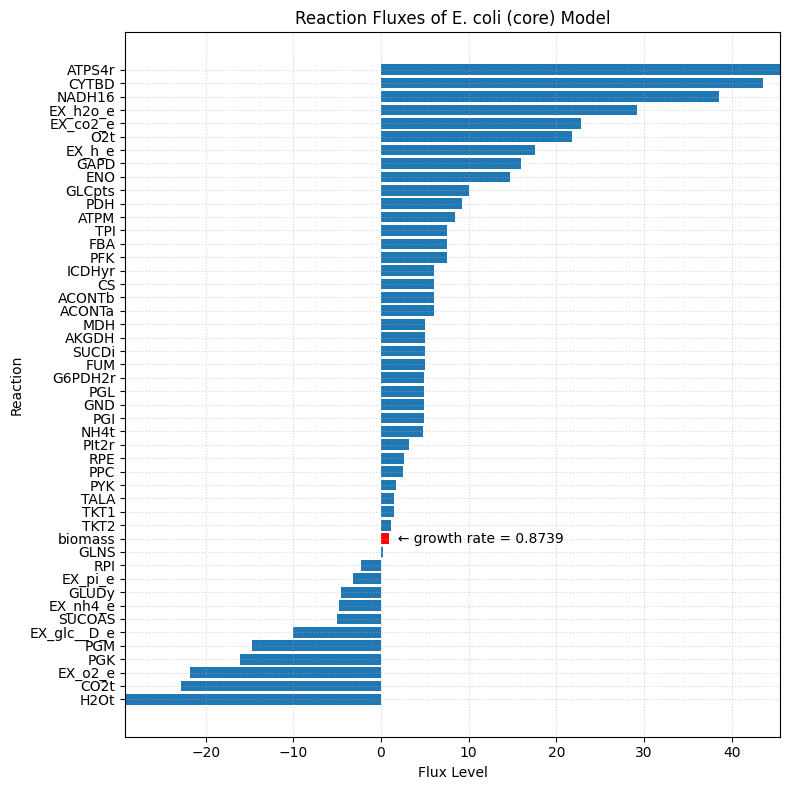

In [33]:
# Sort by level and create horizontal bar plot with biomass highlighted
flux_data = vflux.l.records.sort_values('level', ascending=True)
def visualize_fluxes_records(flux_data, model_name, logscale=False):
    flux_data = flux_data.sort_values('level', ascending=True)
    colors = ['red' if rxn == 'biomass' else 'C0' for rxn in flux_data['rxn']]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.barh(flux_data['rxn'], flux_data['level'], color=colors)
    ax.set_xlabel('Flux Level')
    ax.text(flux_data[flux_data['rxn'] == 'biomass']['level'].values[0],
            'biomass',
            '  ← growth rate = {:.4f}'.format(fba.objective_value),
            va='center',
            fontsize=10)
    # find the maximum absolute flux for setting x-limits, but excluding max
    middle_flux_data = flux_data[(flux_data['level'] > lb_as_min/2) & (flux_data['level'] < ub_as_max/2)]
    x_max = middle_flux_data['level'].max()
    x_min = middle_flux_data['level'].min()
    if logscale:
        ax.set_xscale('symlog')
    ax.set_xlim(x_min, x_max)
    ax.set_ylabel('Reaction')
    ax.set_title(f'Reaction Fluxes of {model_name} Model')
    ax.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
visualize_fluxes_records(flux_data, NAME)


### 3. 2 Critical reaction pathways

A reaction is *critical* if its absence lead to significant negative effect on growth rate, or even stops the growth, while other reactions may be compensated by different reactions. This is a biological relevant task because an organism may have a mutation and lose an enzyme to perform a certain reaction; people want to know or predict the effects of these mutations, or make use of them. Based on this, we can also make an "essential" model of an organism consists of all the critical reactions.

The method of finding critical reactions is simply fixing the flux of one reaction to zero, then solve the same LP, and examine the difference from the previous optimal objective. 

In my implementation, I found that the deletion of some reaction will make the problem *infeasible*. This may relate to some reactions that are important to keep the mass balance condition, absence of them breaks the network and makes it impossible to keep the balance. I detect them and also list these as critical reactions.

In [34]:
growth_rate_with_mutation = []

for idx, rxn_i in enumerate(reactions_df['rxn']):
    print("processing rxn #", idx, end='\r')
    # additional equation constraint
    absence_of_rxn = gp.Equation(gc, f'absence_of_{rxn_i}')
    absence_of_rxn[:] = vflux[rxn_i] == 0
    fba_critical = gp.Model(gc, 'FBA_critical_model', description="Flux Balance Analysis model with reaction absence",
                   objective = growth_rate,
                   equations = [mass_balance, def_growth_rate, absence_of_rxn],
                   sense = gp.Sense.MAX,
                   problem=gp.Problem.LP,   
                   )
    fba_critical.solve(options=gp.Options(equation_listing_limit=0))
    status = ""
    if "Infeasible" in fba_critical.status.name:
        new_growth_rate = 0.0
        status = fba_critical.status.name
    else:
        new_growth_rate = fba_critical.objective_value
        status = fba_critical.status.name
    change = new_growth_rate - fba.objective_value
    growth_rate_with_mutation.append(
        {'rxn': rxn_i, 'growth_rate': new_growth_rate, "change": change, 'status': status})
    
growth_rate_with_mutation = pd.DataFrame(growth_rate_with_mutation)
growth_rate_with_mutation

,rxn,growth_rate,change,status
0,PFK,0.704037,-0.169885,OptimalGlobal
1,PFL,0.873922,0.000000,OptimalGlobal
2,PGI,0.863160,-0.010762,OptimalGlobal
3,PGK,0.000000,-0.873922,OptimalGlobal
4,PGL,0.863813,-0.010108,OptimalGlobal
...,...,...,...,...
90,NADH16,0.211663,-0.662259,OptimalGlobal
91,NADTRHD,0.873922,0.000000,OptimalGlobal
92,NH4t,0.000000,-0.873922,OptimalGlobal
93,O2t,0.211663,-0.662259,OptimalGlobal


In [1]:
flux_change_data = growth_rate_with_mutation.copy()
# drop very small values (maybe numerical errors)
flux_change_data = flux_change_data[np.abs(flux_change_data['change']) > 0.001 * fba.objective_value]


NameError: name 'growth_rate_with_mutation' is not defined

In [36]:
print(f"Number of critical reactions: {flux_change_data.shape[0]}")
print(f"Number of non-zero fluxes in original FBA: {flux_data.shape[0]}")

Number of critical reactions: 48
Number of non-zero fluxes in original FBA: 48


The "core" model we use here is already an essential set of reactions in E. Coli (a minimum metabolic network for E. Coli), so it is expected that all of these reactions are critical reactions. The results make senes. We will do something more in the next part to show the number of critical reactions in a larger model with possible redundant.

Visualization of flux changes due to reaction deletions:

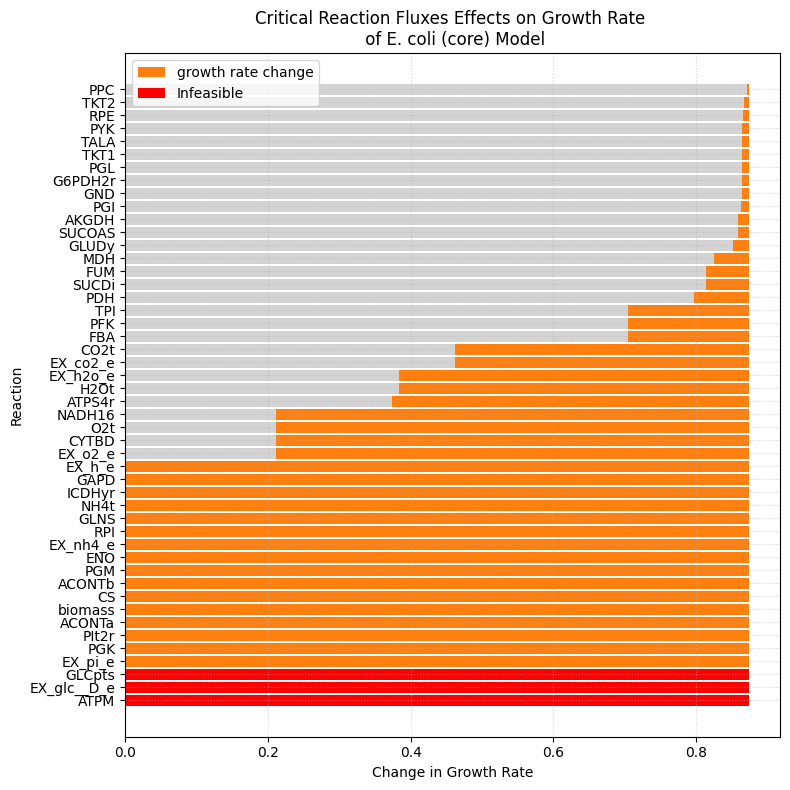

In [43]:

def visualize_flux_change_records(flux_change_data, model_name, logscale=False):
    flux_change_data['is_infeasible'] = flux_change_data['status'].str.contains('Infeasible')

    # Sort: feasible by change (ascending), then infeasible at bottom
    feasible = flux_change_data[~flux_change_data['is_infeasible']].sort_values('change', ascending=True)
    infeasible = flux_change_data[flux_change_data['is_infeasible']].sort_values('change', ascending=True)
    flux_change_data = pd.concat([infeasible, feasible])

    colors = ['red' if is_inf else 'C1' for is_inf in flux_change_data['is_infeasible']]

    fig, ax = plt.subplots(figsize=(8, 8))

    # put reference bars
    ax.barh(flux_change_data['rxn'], fba.objective_value, color='C1', label='growth rate change')

    # plot feasible and infeasible separately for legend
    feasible_data = flux_change_data[~flux_change_data['is_infeasible']]
    infeasible_data = flux_change_data[flux_change_data['is_infeasible']]

    old_optimal = fba.objective_value
    ax.barh(feasible_data['rxn'], feasible_data['change'] + old_optimal, color='lightgrey')
    ax.barh(infeasible_data['rxn'], old_optimal, color='red', label='Infeasible')

    ax.set_xlabel('Change in Growth Rate')
    ax.set_ylabel('Reaction')
    ax.set_title(f'Critical Reaction Fluxes Effects on Growth Rate \n of {model_name} Model')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle=':', alpha=0.5)
    if logscale:
        ax.set_xscale('symlog')
    plt.tight_layout()
    plt.show()
visualize_flux_change_records(flux_change_data, NAME)

We can see there are different levels of decrease in the growth rate caused by deleting different reactions. There are a set of reactions whose absence will cause the growth to stop.

### 3.3 Flux variability analysis

Flux variability analysis (FVA) is that fixing the objective value obtained from FBA (or only allowing a small amount of change) to see what are the available range of each reaction flux. This task is important for researchers to analyze which reactions are sensitive. In real world, people will perform this FVA technique on the reactions they are interested in.

For each reaction of interest $r_i$, we solve 2 LPs. We fix the objective value solved from FBA (I define the constraint is $\geq$ 0.99 * objective), and (1) minimize, (2) maximize the flux $v_i$. This will give the lower bound and upper bound of flux $v_i$.

In [48]:
fva_results = []

for idx, rxn_i in enumerate(reactions_df['rxn']):
    print("processing rxn #", idx, end='\r')
    # fix objective value to optimal
    fixed_objective = fba.objective_value
    fix_growth = gp.Equation(gc, 'fix_growth_rate')
    fix_growth[:] = growth_rate >= 0.99 * fba.objective_value
    
    # objectives for min and max
    flux_obj = gp.Variable(gc, 'min_flux_obj', description="min flux objective")
    def_flux_obj = gp.Equation(gc, 'define_min_flux_obj')
    def_flux_obj[:] = flux_obj == vflux[rxn_i]
    
    # minimize flux
    fva_min_model = gp.Model(gc, f'FVA_min_model_{rxn_i}', description="FVA lower bound model",
                   objective = flux_obj,
                   equations = [mass_balance, def_growth_rate, fix_growth, def_flux_obj],
                   sense = gp.Sense.MIN,
                   problem=gp.Problem.LP,
                   )
    fva_min_model.solve(options=gp.Options(equation_listing_limit=0))
    
    fva_lb_i = fva_min_model.objective_value

    # maximize flux
    fva_max_model = gp.Model(gc, f'FVA_max_model_{rxn_i}', description="FVA upper bound model",
                   objective = flux_obj,
                   equations = [mass_balance, def_growth_rate, fix_growth, def_flux_obj],
                   sense = gp.Sense.MAX,
                   problem=gp.Problem.LP,
                   )
    fva_max_model.solve(options=gp.Options(equation_listing_limit=0))
    fva_ub_i = fva_max_model.objective_value

    # get results
    fva_results.append({
        'rxn': rxn_i,
        'fva_lb': fva_lb_i,
        'fva_ub': fva_ub_i,
        'range': fva_ub_i - fva_lb_i
    })
fva_results = pd.DataFrame(fva_results)

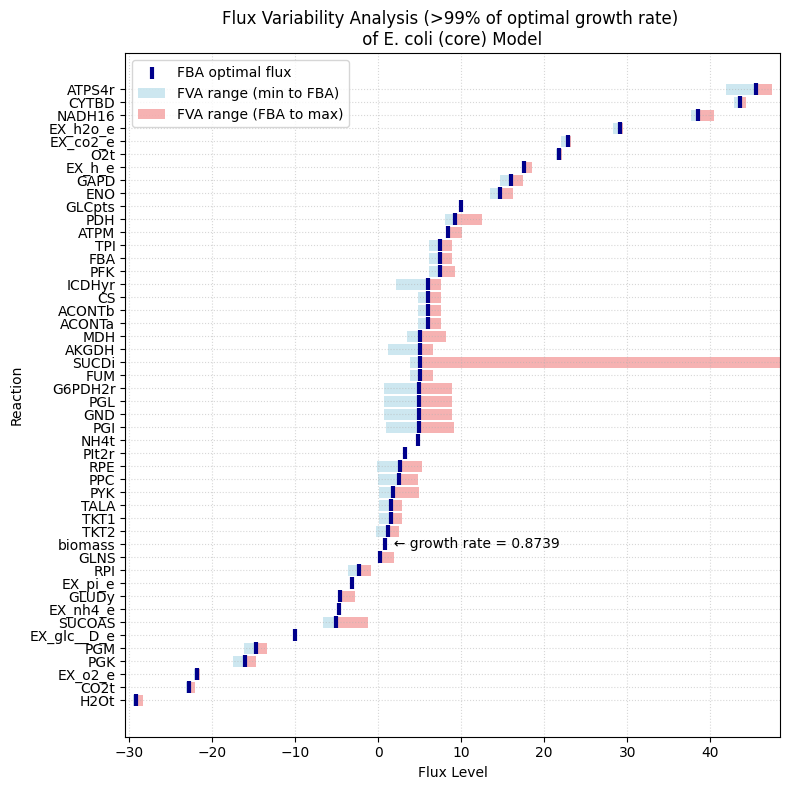


Showing 48 reactions with non-zero FBA flux
X-axis range: [-30.48, 48.41]


In [49]:
def visualize_fva_results(fva_results, flux_data, growth_rate_value, model_name, logscale=False):
    """
    This function is written by Claude Sonnet 4.5
    Visualize Flux Variability Analysis results with min-max ranges and FBA optimal fluxes.
    
    Parameters:
    -----------
    fva_results : pd.DataFrame
        DataFrame with columns: 'rxn', 'fva_lb', 'fva_ub', 'range'
    flux_data : pd.DataFrame or gamspy records
        FBA flux data with columns: 'rxn', 'level'
    growth_rate_value : float
        The optimal growth rate from FBA
    model_name : str
        Name of the model for the plot title
    """
    # Handle both DataFrame and GAMS records
    if hasattr(flux_data, 'records'):
        flux_df = flux_data.records[['rxn', 'level']].rename(columns={'level': 'fba_flux'})
    else:
        flux_df = flux_data[['rxn', 'level']].rename(columns={'level': 'fba_flux'})
    
    # Merge FVA results with original FBA flux data
    fva_with_fba = fva_results.merge(flux_df, on='rxn', how='left')
    
    # Filter reactions with non-zero FBA flux for better visualization
    fva_plot_data = fva_with_fba[fva_with_fba['fba_flux'].abs() > 1e-6].copy()
    
    # Sort by FBA flux value
    fva_plot_data = fva_plot_data.sort_values('fba_flux', ascending=True)
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create stacked bars: from min to FBA flux, then from FBA flux to max
    width1 = fva_plot_data['fba_flux'] - fva_plot_data['fva_lb']
    width2 = fva_plot_data['fva_ub'] - fva_plot_data['fba_flux']
    
    # Plot the range as two stacked segments
    ax.barh(fva_plot_data['rxn'], width1, left=fva_plot_data['fva_lb'], 
            color='lightblue', alpha=0.6, label='FVA range (min to FBA)')
    ax.barh(fva_plot_data['rxn'], width2, left=fva_plot_data['fba_flux'], 
            color='lightcoral', alpha=0.6, label='FVA range (FBA to max)')
    
    # Highlight the FBA optimal flux value with thick vertical markers
    ax.scatter(fva_plot_data['fba_flux'], fva_plot_data['rxn'], 
               color='darkblue', s=80, marker='|', linewidths=3, 
               zorder=5, label='FBA optimal flux')
    
    # Highlight biomass reaction
    if 'biomass' in fva_plot_data['rxn'].values:
        biomass_flux = fva_plot_data[fva_plot_data['rxn'] == 'biomass']['fba_flux'].values[0]
        ax.text(biomass_flux, 'biomass', 
                f'  ← growth rate = {growth_rate_value:.4f}', 
                va='center', fontsize=10)
    
    # Set x-axis limits, filtering out extreme outliers (abs > 500)
    reasonable_data = fva_plot_data[(fva_plot_data['fva_lb'] > lb_as_min/2) & (fva_plot_data['fva_ub'] < ub_as_max/2)]
    if len(reasonable_data) > 0:
        x_max = reasonable_data['fva_ub'].max() + 1
        x_min = reasonable_data['fva_lb'].min() - 1
    else:
        x_max = fva_plot_data['fva_ub'].max() + 1
        x_min = fva_plot_data['fva_lb'].min() - 1
    ax.set_xlim(x_min, x_max)
    
    ax.set_xlabel('Flux Level')
    ax.set_ylabel('Reaction')
    ax.set_title(f'Flux Variability Analysis (>99% of optimal growth rate) \n of {model_name} Model ')
    ax.legend(loc='best')
    ax.grid(True, linestyle=':', alpha=0.5)
    if logscale:
        ax.set_xscale('symlog')
    plt.tight_layout()
    plt.show()
    
    print(f"\nShowing {len(fva_plot_data)} reactions with non-zero FBA flux")
    print(f"X-axis range: [{x_min:.2f}, {x_max:.2f}]")

# Use the function
visualize_fva_results(fva_results, flux_data, fba.objective_value, NAME)

The results of FVA can give biologists a sense of how much flexibility is allowed for certain reaction flux. And we see in this model the fluxes that have large magnitudes tend to have smaller ranges, meaning that the cell is highly rely on these reactions to have a high growth rate. These contains the reactions related to respiration (O2, CO2), water transport (H2O), and energy production (ATP, NADH), which is very consistent with the biologists' view.

What happen if we fix the growth rate to be exactly the optimal?

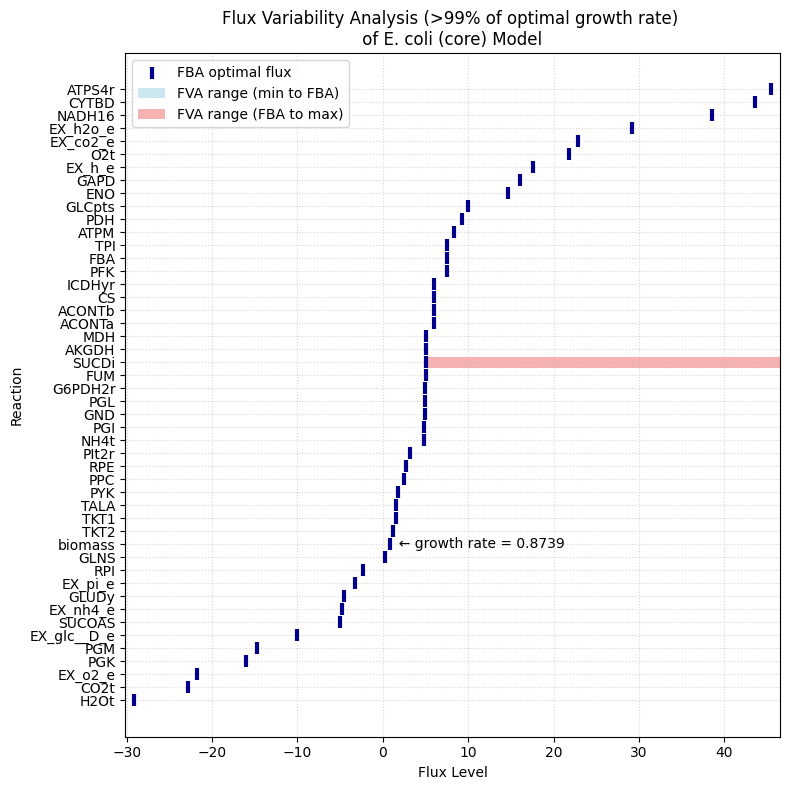


Showing 48 reactions with non-zero FBA flux
X-axis range: [-30.18, 46.51]


In [50]:
fva_results = []

for idx, rxn_i in enumerate(reactions_df['rxn']):
    print("processing rxn #", idx, end='\r')
    # fix objective value to optimal
    fixed_objective = fba.objective_value
    fix_growth = gp.Equation(gc, 'fix_growth_rate')
    fix_growth[:] = growth_rate == fba.objective_value
    
    # objectives for min and max
    flux_obj = gp.Variable(gc, 'min_flux_obj', description="min flux objective")
    def_flux_obj = gp.Equation(gc, 'define_min_flux_obj')
    def_flux_obj[:] = flux_obj == vflux[rxn_i]
    
    # minimize flux
    fva_min_model = gp.Model(gc, f'FVA_min_model_{rxn_i}', description="FVA lower bound model",
                   objective = flux_obj,
                   equations = [mass_balance, def_growth_rate, fix_growth, def_flux_obj],
                   sense = gp.Sense.MIN,
                   problem=gp.Problem.LP,
                   )
    fva_min_model.solve(options=gp.Options(equation_listing_limit=0))
    
    fva_lb_i = fva_min_model.objective_value

    # maximize flux
    fva_max_model = gp.Model(gc, f'FVA_max_model_{rxn_i}', description="FVA upper bound model",
                   objective = flux_obj,
                   equations = [mass_balance, def_growth_rate, fix_growth, def_flux_obj],
                   sense = gp.Sense.MAX,
                   problem=gp.Problem.LP,
                   )
    fva_max_model.solve(options=gp.Options(equation_listing_limit=0))
    fva_ub_i = fva_max_model.objective_value

    # get results
    fva_results.append({
        'rxn': rxn_i,
        'fva_lb': fva_lb_i,
        'fva_ub': fva_ub_i,
        'range': fva_ub_i - fva_lb_i
    })
fva_results = pd.DataFrame(fva_results)

visualize_fva_results(fva_results, flux_data, fba.objective_value, NAME)

We see here only one reaction can have a flexible range, but that one can only be higher. None of these reaction can change to zero without lowering the optimal growth rate. This aligns with the previous critical pathway results: all these reactions are critical.

## 4. General pipeline and results.

Here, we build a general solver for metabolic networks, consists of data processing, FBA, critical pathways, FVA models, and post analysis functions. Then I can build a small benchmark dataset to see the performances. 

In [ ]:
# select one model
NAME = "E. coli (core)"

names_dict = {"E. coli (core)":"e_coli_core",
              "H. pylori": 'iIT341',
#         "E. coli": "iAF1260",
         "Brewer's yeast (S. cerevisiae)": "iMM904", 
         "House mouse (M. musculus)": "iMM1415"}

def fetch_data(model_name, save_loc=None):
    url = f"http://bigg.ucsd.edu/static/models/{model_name}.json"
    response = requests.get(url)
    if save_loc:
        with open(save_loc, "wb") as f:
            f.write(response.content)
    return response.json()

def get_data_json(model_name):
    if os.path.exists(f"data/{names_dict[model_name]}.json"):
        with open(f"data/{names_dict[model_name]}.json", "r") as f:
            data_json = json.load(f)
            print("Loaded from local file.")
    else:
        if not os.path.exists("data"):
            os.makedirs("data")
        data_json = fetch_data(names_dict[model_name], f"data/{names_dict[model_name]}.json")
        print("Fetched from web and saved locally.")
    return data_json
def data_pipeline(model_name):
    data_json = get_data_json(model_name)
    print(data_json.keys())

    metabolites_df = pd.DataFrame(data_json['metabolites'])

    reactions_df = pd.DataFrame(data_json['reactions'])
    lb_as_min = reactions_df['lower_bound'].min()
    ub_as_max = reactions_df['upper_bound'].max()

reactions_df = pd.DataFrame(data_json['reactions'])

reaction_mat_df = pd.concat([reactions_df[['id', 'name']],   
           pd.DataFrame(reactions_df['metabolites'].to_list()).fillna(0) ],
           axis=1)
# find biomass reaction
biomass_rxn_idx = reaction_mat_df['name'].str.contains('biomass', case=False)
# replace id to "biomass"
reaction_mat_df.at[biomass_rxn_idx.idxmax(), 'id'] = 'biomass'
reactions_df.at[biomass_rxn_idx.idxmax(), 'id'] = 'biomass'
# get columes other than id name
display(reaction_mat_df[reaction_mat_df.columns.difference(['id', 'name'])].head())

# Convert wide format to long format
reaction_mat_long = pd.melt(
    reaction_mat_df, 
    id_vars=['id'], 
    value_vars=[col for col in reaction_mat_df.columns if col not in ['id', 'name']],
    var_name='metabolite', 
    value_name='coefficient'
)

# Display the result
print(f"Shape: {reaction_mat_long.shape}")
reaction_mat_long.columns = ['rxn', 'metabolite', 'coefficient']
reaction_mat_long.head(5)
reactions_df.rename(columns={'id':'rxn'}, inplace=True)